In [1071]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit.visualization import plot_histogram

# Shor's code algorithm

The Shor's code algorithm encodes a single qubit into a 9-qubit entangled state.
Qubits 0, 3, and 6 are the data qubits, while the others are repetition qubits.

## Encoder

In [1072]:
q = QuantumRegister(9, 'q')
c = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(q, c)
circuit.cx(0, 3)
circuit.cx(0, 6)
circuit.h([0, 3, 6])
for i in [0, 3, 6]:
    circuit.cx(i, i+1)
    circuit.cx(i, i+2)

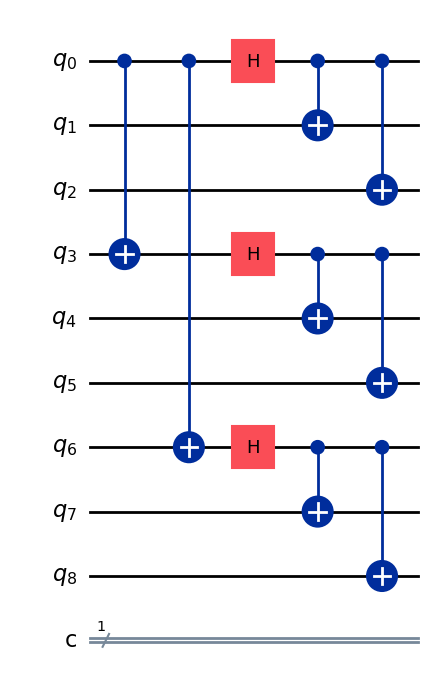

In [1073]:
circuit.draw('mpl')

In [1074]:
state = Statevector.from_instruction(circuit)
state.draw("latex")

<IPython.core.display.Latex object>

## Introduce error

In [1075]:
circuit.barrier()
circuit.id(0)
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=9, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(9, 'q'), 0), Qubit(QuantumRegister(9, 'q'), 1), Qubit(QuantumRegister(9, 'q'), 2), Qubit(QuantumRegister(9, 'q'), 3), Qubit(QuantumRegister(9, 'q'), 4), Qubit(QuantumRegister(9, 'q'), 5), Qubit(QuantumRegister(9, 'q'), 6), Qubit(QuantumRegister(9, 'q'), 7), Qubit(QuantumRegister(9, 'q'), 8)), clbits=())

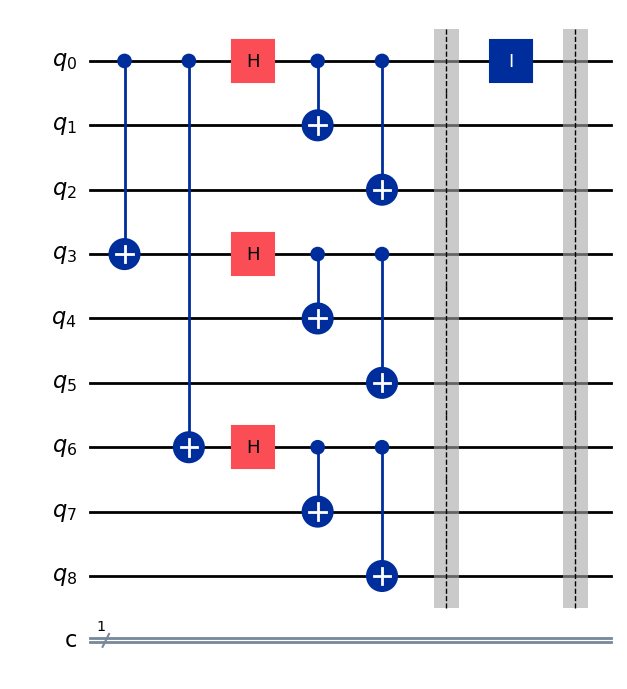

In [1076]:
circuit.draw('mpl')

## Decoder

In [1077]:
# for i in [0, 3, 6]:
#     circuit.cx(i, i + 1)
#     circuit.cx(i, i + 2)
#     #circuit.ccx(i + 2, i + 1, i)
# circuit.h([0, 3, 6])
# circuit.cx(0, 3)
# circuit.cx(0, 6)
# #circuit.ccx(6, 3, 0)

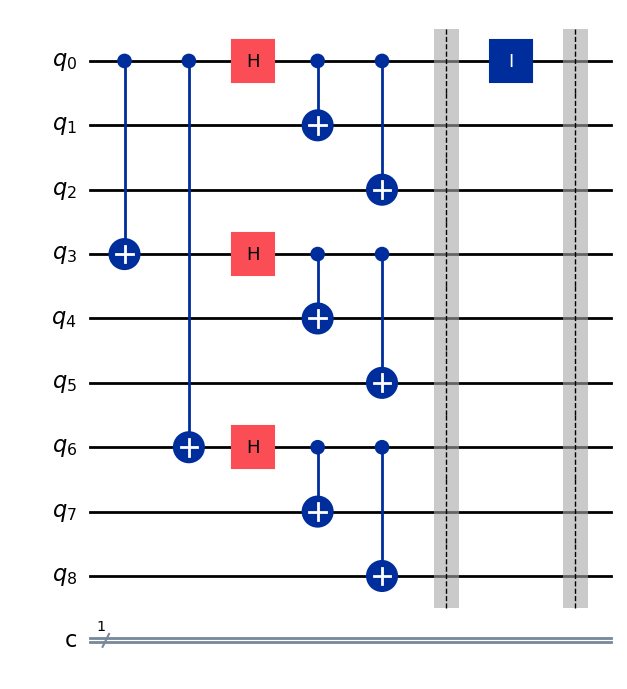

In [1078]:
circuit.draw('mpl')

## Noise simulation

Define the error model for the noise simulation. 

In [1079]:
p_error = 1.0 # probability of error
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘


In [1080]:
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘


In [1081]:
noise_model = NoiseModel()
noise_model.add_quantum_error(bitphase_flip, ['id'], [0])
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0]
  Specific qubit errors: [('id', (0,))]


In [1082]:
def channel(input):
    encoded = input.compose(circuit)
    encoded.measure(0, 0)
    unencoded = encoded.copy()
    return encoded, unencoded

In [1083]:
input_0 = QuantumCircuit(9) # Prepare |0> state
input_1 = QuantumCircuit(9) # Prepare |1> state by applying an X gate
# Apply an ry gate with θ = π to rotate the qubit to |1>
input_1.ry(3.14159, 0)  # Approximation of π
encoded_0, unencoded_0 = channel(input_0)
encoded_1, unencoded_1 = channel(input_1)

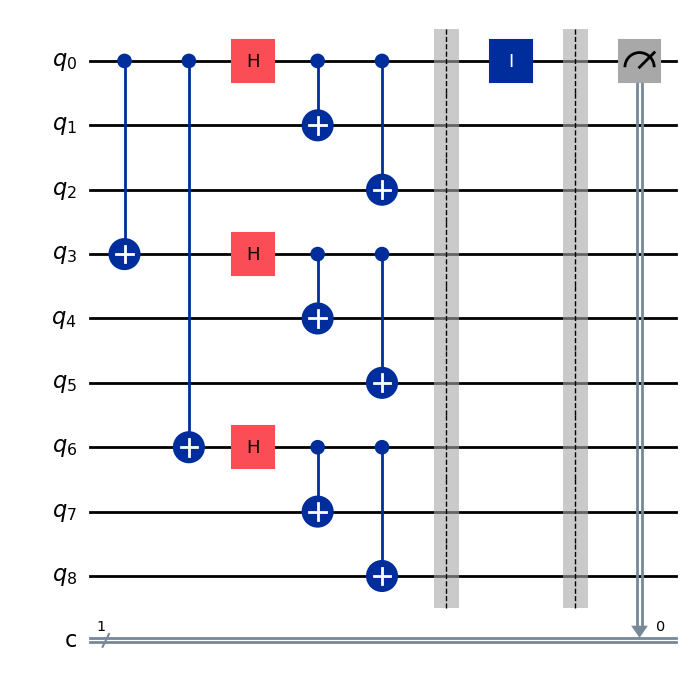

In [1084]:
encoded_0.draw('mpl')

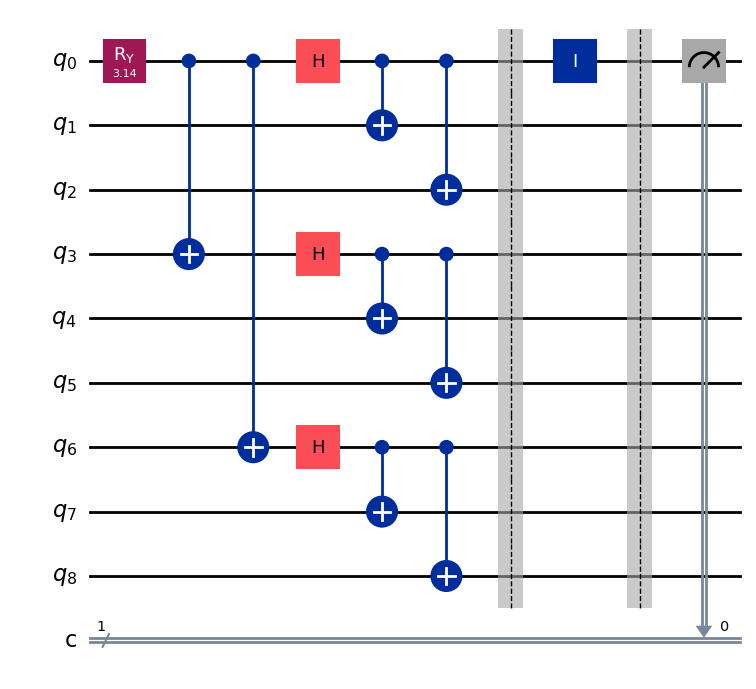

In [1085]:
encoded_1.draw('mpl')

In [1086]:
backend = Aer.get_backend('qasm_simulator')
compiled_enc_0 = transpile(encoded_0, backend)
compiled_enc_1 = transpile(encoded_1, backend)
compiled_unenc_0 = transpile(unencoded_0, backend)
compiled_unenc_1 = transpile(unencoded_1, backend)
results_enc_0 = backend.run(compiled_enc_0, shots=1024, noise_model=noise_model).result().get_counts()
results_enc_1 = backend.run(compiled_enc_1, shots=1024, noise_model=noise_model).result().get_counts()
results_unenc_0 = backend.run(compiled_unenc_0, shots=1024).result().get_counts()
results_unenc_1 = backend.run(compiled_unenc_1, shots=1024).result().get_counts()

In [1087]:
print("\nResults for encoded qubits:")
print(f"Encoded |0>: {results_enc_0}")
print(f"Encoded |1>: {results_enc_1}")
print("\nResults for unencoded qubits:")
print(f"Unencoded |0>: {results_unenc_0}")
print(f"Unencoded |1>: {results_unenc_1}")


Results for encoded qubits:
Encoded |0>: {'0': 485, '1': 539}
Encoded |1>: {'1': 504, '0': 520}

Results for unencoded qubits:
Unencoded |0>: {'0': 500, '1': 524}
Unencoded |1>: {'1': 487, '0': 537}


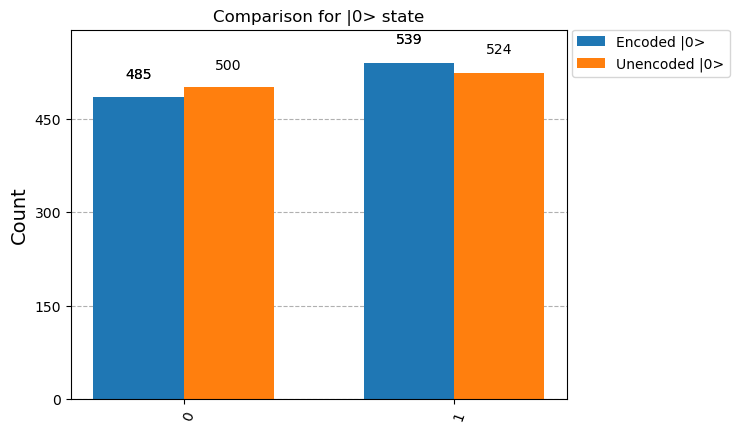

In [1088]:
plot_histogram(
    [results_enc_0, results_unenc_0],
    legend=['Encoded |0>', 'Unencoded |0>'],
    title="Comparison for |0> state"
)

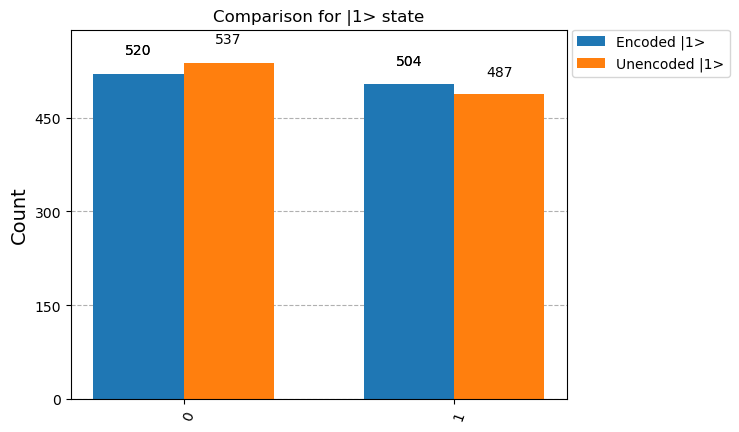

In [1089]:
plot_histogram(
    [results_enc_1, results_unenc_1],
    legend=['Encoded |1>', 'Unencoded |1>'],
    title="Comparison for |1> state"
)